In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

import warnings
warnings.filterwarnings('ignore')

In [2]:
from examples.data.longi_simulation import longi_sim
import torch
torch.manual_seed(0)

n_longi_feats = 5
coefs = torch.Tensor([1, 0, 1., 0, 5., 0.])
coef_mask = torch.Tensor([1, 1, 1, 1, 1, 1])
important_feat_mask = torch.Tensor([0, 1, 0, 0, 0])
theta = torch.Tensor([0., -.3, 0., .2, 0.])
hurst_list = [0.9, 0.45, 0.85, 0.35, 0.8]
paths, surv_labels, static_feature, factor, ddh_info_sup, traj, org_paths = longi_sim.Simulation().load(n_samples=1000, n_sampling_times = 200, end_time = 10, 
                                         dim=n_longi_feats + 1, intercept=True, threshold=12,
                                         coefs=coefs, coefs_mask=coef_mask, 
                                         important_feat_mask=important_feat_mask,
                                         hurst_list=hurst_list,
                                         theta=theta, n_static_feats=3, show=False)
important_feat_mask = (coefs != 0).int()
longi_feat_list = ['X'+ str(i+1) for i in range(n_longi_feats)]
n_samples, n_sampling_times, _ = paths.shape
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
paths_init = paths.clone() # for MC true survival function

In [3]:
# Setup for experiment training
train_test_share = .8
n_samples = paths.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

paths_train = paths[train_index, :, :]
surv_labels_train = surv_labels[train_index, :]
if static_feature is not None:
    static_feature_train = static_feature[train_index, :]
else:
    static_feature_train = None

paths_test = paths[test_index, :, :]
surv_labels_test = surv_labels[test_index, :]
if static_feature is not None:
    static_feature_test = static_feature[test_index, :]
else:
    static_feature_test = None

## Cox Signature

In [4]:
### TRAINING
from examples.learner.coxsig import CoxSignature
sig_order = 2
coxsig = CoxSignature(sig_level=sig_order, alphas=3e-1, max_iter=200)
coxsig.train(paths_train, surv_labels_train, static_feature_train, plot_loss=False)

In [5]:
# setup
sampling_times = np.array(paths[0, :, 0])
dt = sampling_times[1] - sampling_times[0]
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.5, .75])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
pred_times = np.array([1.95, 3.75])
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)

# evaluation
c_index = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'c_index', static_feat = static_feature_test)
bs = coxsig.score(paths_test, surv_labels_test, pred_times, eval_times, 'bs', static_feat = static_feature_test)

In [6]:
from examples.learner.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext

cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)

dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat, bin_feat)
dynamic_deephit.sampling_times = np.array(sampling_times)
dynamic_deephit.ddh_info_sup = ddh_info_sup

In [7]:
# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]

tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

# train
dynamic_deephit.train(tr_data_full, is_trained=True, plot_loss=False, ckpt_dir="./dynamic_deephit_ckpt/simulation")


# performance evaluation
from examples.learner.utils import score
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.5, .75])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
pred_times = np.array([1.95, 3.75])
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .05) - pred_times))
eval_times = np.array(eval_times)
# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(te_data, te_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
ddh_bs = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_times[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = surv_labels_test[:, 0]
    surv_inds_test = surv_labels_test[:, 1]
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_times)
    ddh_bs[j] = score("bs", surv_labels_, surv_labels_, 
                      surv_preds_, eval_times)

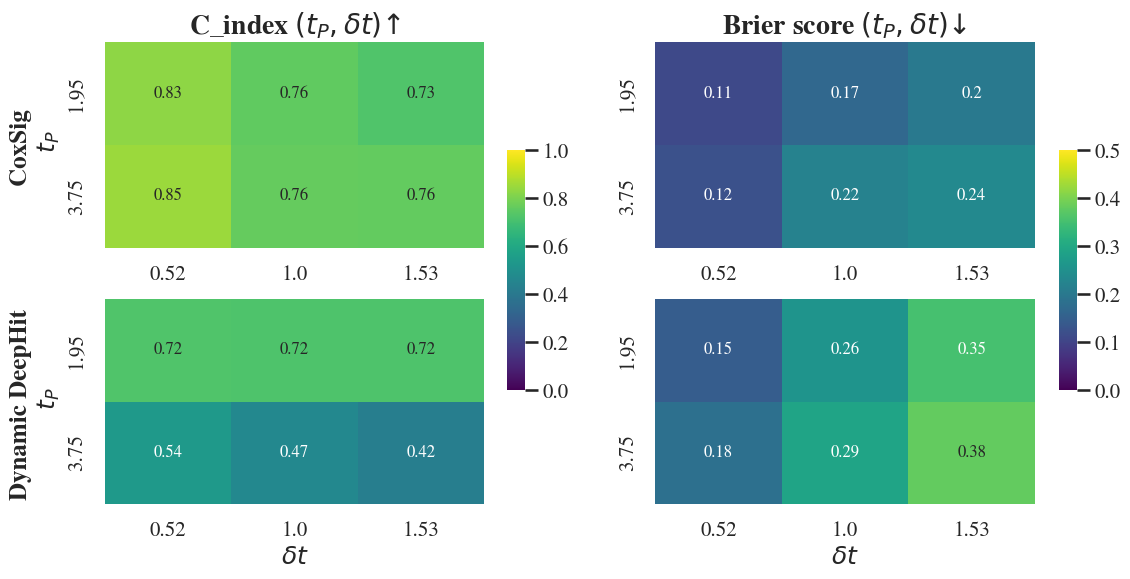

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
for ax_ in axs:
    for ax in ax_:
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

plt.subplots_adjust(hspace=.25, wspace=0.45)
cbar_ax_1 = fig.add_axes([0.46, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
vmin = 0.
vmax = 1
sns.heatmap(c_index, annot=True, annot_kws={"size": 12}, cmap="viridis", vmin=vmin, vmax=vmax, ax=axs[0, 0], cbar=False)
axs[0, 0].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[0, 0].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].tick_params(axis='x', labelsize=15)
axs[0, 0].set_ylabel("CoxSig \n $t_P$", fontweight="semibold", fontsize=18)
axs[0, 0].set_title("C_index $(t_P, \delta t) \u2191$", fontweight="semibold", fontsize=20)
axs[0, 0].legend().remove()

sns.heatmap(ddh_cindex, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[1, 0], vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax_1)
axs[1, 0].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[1, 0].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[1, 0].tick_params(axis='y', labelsize=15)
axs[1, 0].tick_params(axis='x', labelsize=15)
axs[1, 0].set_xlabel("$\delta t$", fontweight="semibold", fontsize=18)
axs[1, 0].set_ylabel("Dynamic DeepHit \n $t_P$", fontweight="semibold", fontsize=18)
axs[1, 0].collections[0].colorbar.ax.tick_params(labelsize=15)
axs[1, 0].legend().remove()

cbar_ax_2 = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
vmin = 0
vmax = .5

sns.heatmap(bs, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[0, 1], vmin=vmin, vmax=vmax, cbar=False)
axs[0, 1].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[0, 1].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[0, 1].tick_params(axis='y', labelsize=15)
axs[0, 1].tick_params(axis='x', labelsize=15)
axs[0, 1].set_title("Brier score $(t_P, \delta t) \u2193$", fontweight="semibold", fontsize=20)
axs[0, 1].legend().remove()


sns.heatmap(ddh_bs, annot=True, annot_kws={"size": 12}, cmap="viridis", ax=axs[1, 1], vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cbar_ax_2)
axs[1, 1].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs[1, 1].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs[1, 1].tick_params(axis='y', labelsize=15)
axs[1, 1].tick_params(axis='x', labelsize=15)
axs[1, 1].set_xlabel("$\delta t$", fontweight="semibold", fontsize=18)
axs[1, 1].collections[0].colorbar.ax.tick_params(labelsize=15)
axs[1, 1].legend().remove()

# plt.tight_layout()
plt.savefig('figures/simu_perf.pdf', bbox_inches="tight")

### Expected remaining survival time as prediction function

In [9]:
all_shap_CoxSig= np.load('results/shap_simu_mean_CoxSig.npy', allow_pickle=True)
all_shap_DDH= np.load('results/shap_simu_mean_DDH.npy', allow_pickle=True)
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.5, .75])
pred_times = np.quantile(np.array(tte), quantile_pred_times)

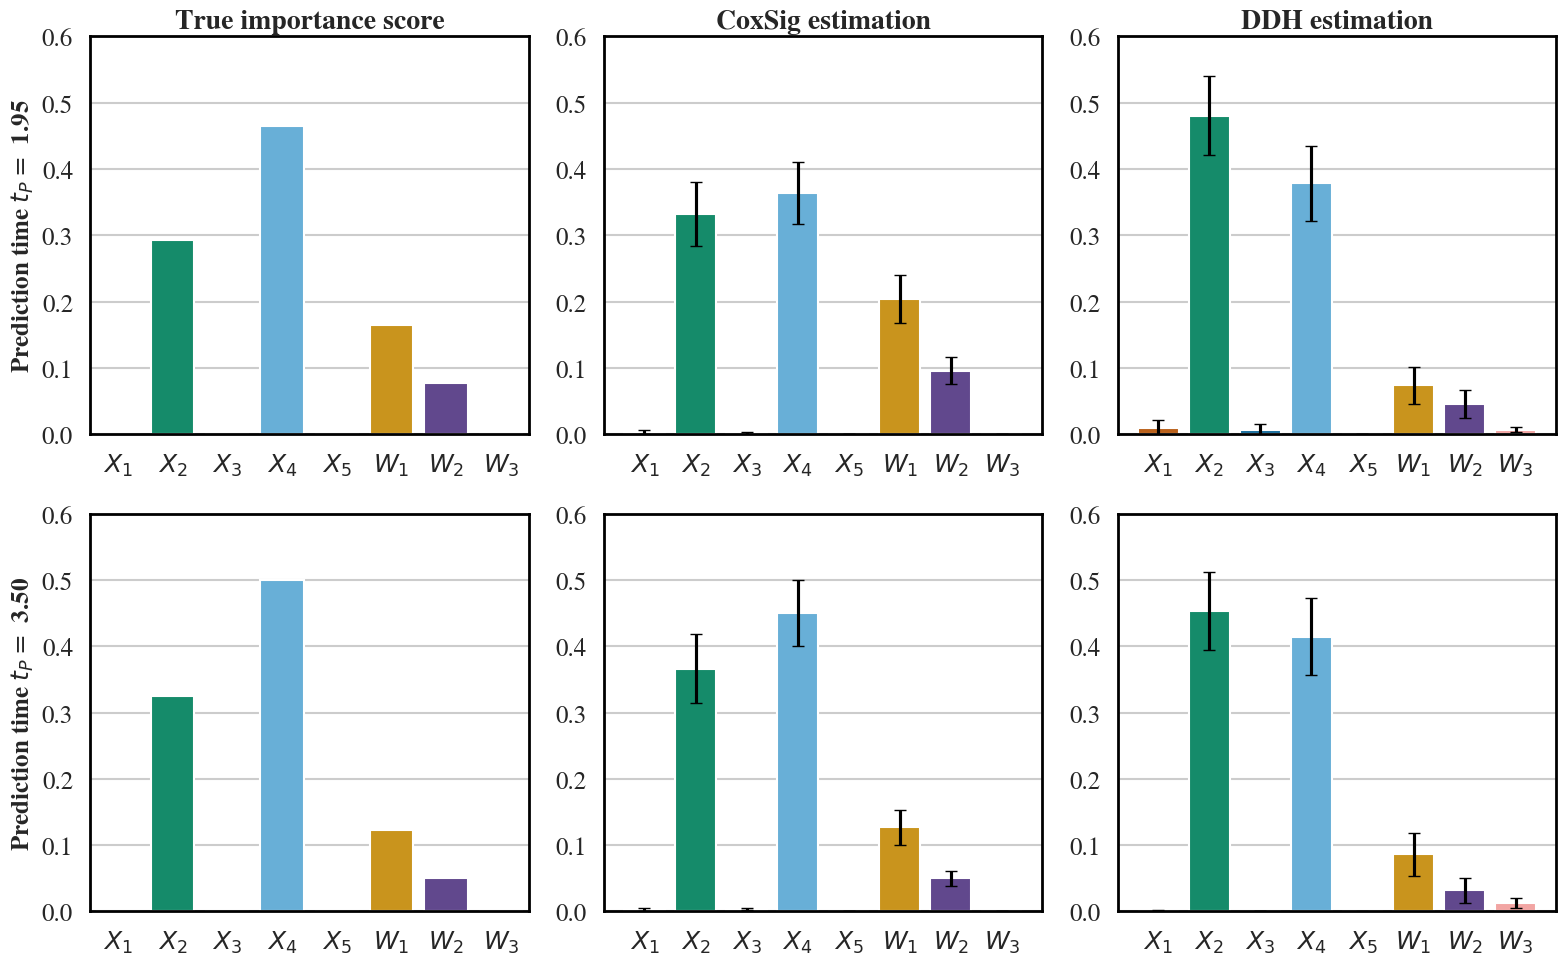

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
n_static_feat = static_feature.shape[1]
x_labels = ["$X_" + str(i + 1) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i + 1) + "$" for i in range(n_static_feat)]
dt = sampling_times[1] - sampling_times[0]

idx_pred_t = 0
pred_time = pred_times[idx_pred_t]
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)

n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
n_merged_time = 5
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx-1:pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
factor_avg = (
    factor_ext
    .reshape(factor_ext.shape[0], -1, n_merged_time)
    .mean(axis=2, keepdims=True)
    .repeat(n_merged_time, axis=2)
    .reshape(factor_ext.shape[0], n_sampling_times)
)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)
sns.barplot(data=score_df, x="feat", y="value", ax=axs[0, 0], palette=colors)
axs[0, 0].tick_params(axis='x', labelsize=18) 
axs[0, 0].tick_params(axis='y', labelsize=18)
axs[0, 0].set_xlabel("")
axs[0, 0].set_ylabel("")
axs[0, 0].set_ylim(0, .6)
axs[0, 0].set_title("True importance score", fontweight="semibold", fontsize=20) 
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")


##################  ESTIMATION   ########################
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[0, 1], palette=colors)
axs[0, 1].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[0, 1].tick_params(axis='x', labelsize=18) 
axs[0, 1].tick_params(axis='y', labelsize=18)
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[0, 1].set_ylim(0, .6)
axs[0, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)




shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[0, 2], palette=colors)
axs[0, 2].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[0, 2].tick_params(axis='x', labelsize=18) 
axs[0, 2].tick_params(axis='y', labelsize=18)
axs[0, 2].set_xlabel("")
axs[0, 2].set_ylabel("")
axs[0, 2].set_ylim(0, .6)
axs[0, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)



idx_pred_t = 1
pred_time = pred_times[idx_pred_t]
n_merged_time = 5
pred_time_idx = (int((pred_time  / (sampling_times[1] - sampling_times[0]))) // n_merged_time) * n_merged_time
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx-1:pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
factor_avg = (
    factor_ext
    .reshape(factor_ext.shape[0], -1, n_merged_time)
    .mean(axis=2, keepdims=True)
    .repeat(n_merged_time, axis=2)
    .reshape(factor_ext.shape[0], n_sampling_times)
)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)
sns.barplot(data=score_df, x="feat", y="value", ax=axs[1, 0], palette=colors)
axs[1, 0].tick_params(axis='x', labelsize=18) 
axs[1, 0].tick_params(axis='y', labelsize=18)
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")
axs[1, 0].set_ylim(0, .6)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx) * dt), fontsize=18, fontweight="semibold")


##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[1, 1], palette=colors)
axs[1, 1].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[1, 1].tick_params(axis='x', labelsize=18) 
axs[1, 1].tick_params(axis='y', labelsize=18)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")
axs[1, 1].set_ylim(0, .6)




shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[1, 2], palette=colors)
axs[1, 2].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[1, 2].tick_params(axis='x', labelsize=18) 
axs[1, 2].tick_params(axis='y', labelsize=18)
axs[1, 2].set_xlabel("")
axs[1, 2].set_ylabel("")
axs[1, 2].set_ylim(0, .6)


plt.tight_layout()
plt.savefig('figures/shap_simu_mean_score_per_feat.pdf')
plt.show()

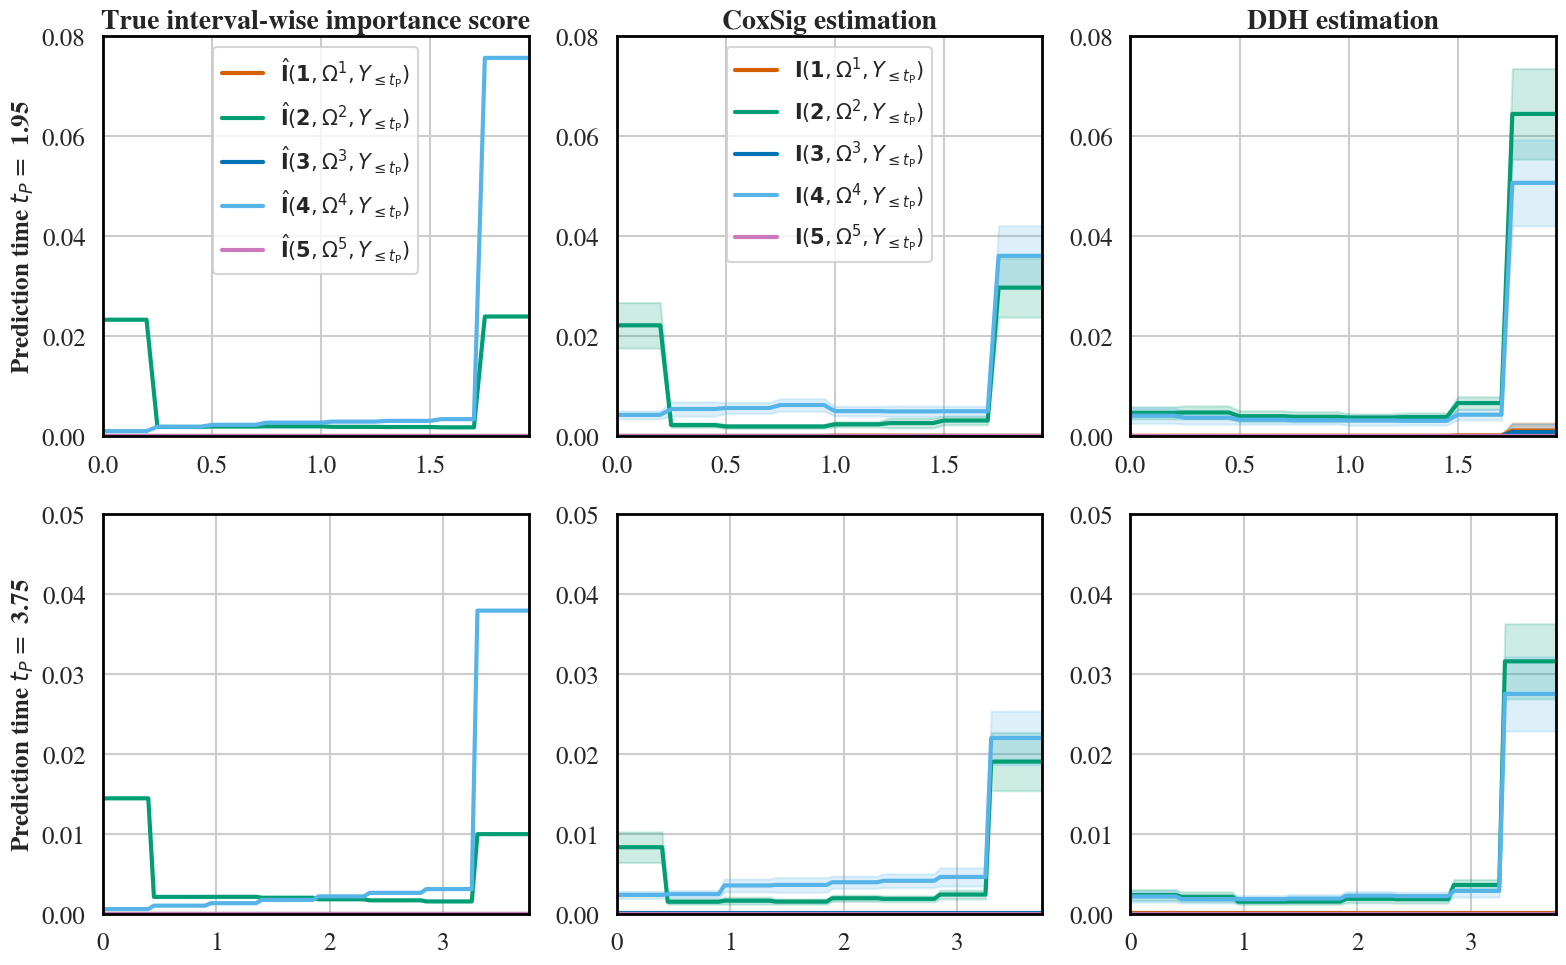

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
x_labels = ["$X_" + str(i) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i) + "$" for i in range(n_static_feat)]

idx_pred_t = 0
dt = sampling_times[1] - sampling_times[0]
##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))

pred_time = pred_times[idx_pred_t]
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx -1 :pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
interval = [0 , 5, 10, 15, 21, 26, 31, 35, 40]
factor_avg = factor_ext.copy()
for l in range(len(interval) - 1):
    factor_avg[:, interval[l] : interval[l+1]] = factor_avg[:, interval[l] : interval[l+1]].mean(axis=1).reshape(-1, 1)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)

# ---- LONGITUDINAL feature importance
for l, f in enumerate(factor_avg[:n_longi_feats]):
    label = f"${{\\hat{{\mathbf{{I}}}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[0, 0].plot(sampling_times[: len(f)][:pred_time_idx], f[:pred_time_idx], label=label, linewidth=3, color=colors[l % len(colors)], linestyle="-")
axs[0, 0].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 0].tick_params(axis='x', labelsize=18)
axs[0, 0].tick_params(axis='y', labelsize=18)
axs[0, 0].set_ylim(0, .08)
axs[0, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 0].set_title("True interval-wise importance score", fontweight="semibold", fontsize=20)
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
# axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx + 1) * dt), fontsize=18, fontweight="semibold")

for l in range(n_longi_feats):
    label = f"${{\mathbf{{I}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[0, 1].plot(sampling_times, mean_shap_at_pt[l], linewidth=3, color=colors[l], label=label)
    axs[0, 1].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[0, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
axs[0, 1].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 1].tick_params(axis='x', labelsize=18) 
axs[0, 1].tick_params(axis='y', labelsize=18)
axs[0, 1].set_ylim(0, .08)
axs[0, 1].set_xlim(0, (pred_time_idx - 1) * dt)

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
# n_expl_samples = all_shap.shape[1]
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
for l in range(n_longi_feats):
    axs[0, 2].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[0, 2].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[0, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[0, 2].tick_params(axis='x', labelsize=18) 
axs[0, 2].tick_params(axis='y', labelsize=18)
axs[0, 2].set_ylim(0, .08)
axs[0, 2].set_xlim(0, (pred_time_idx - 1) * dt)


idx_pred_t = 1
dt = sampling_times[1] - sampling_times[0]
##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))


pred_time = pred_times[idx_pred_t]
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx -1 :pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
interval = [0 , 9, 19, 28, 38, 47, 57, 66, 76]
factor_avg = factor_ext.copy()
for l in range(len(interval) - 1):
    factor_avg[:, interval[l] : interval[l+1]] = factor_avg[:, interval[l] : interval[l+1]].mean(axis=1).reshape(-1, 1)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)

# ---- LONGITUDINAL feature importance
for l, f in enumerate(factor_avg[:n_longi_feats]):
    label = f"${{\\hat{{\mathbf{{I}}}}}}(\mathbf{{l+1}},\Omega^{l+1},Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[1, 0].plot(sampling_times[: len(f)][:pred_time_idx], f[:pred_time_idx], label=label, linewidth=3, color=colors[l % len(colors)], linestyle="-")
# axs[1, 0].legend(ncols=2, fontsize=12, loc="upper left")
axs[1, 0].legend().remove()
axs[1, 0].tick_params(axis='x', labelsize=18)
axs[1, 0].tick_params(axis='y', labelsize=18)
axs[1, 0].set_ylim(0, .05)
axs[1, 0].set_xlim(0, (pred_time_idx - 1) * dt)
# axs[1, 0].set_title("True interval-wise importance score", fontweight="semibold", fontsize=20)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
# axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx) * dt), fontsize=18, fontweight="semibold")

for l in range(n_longi_feats):
    axs[1, 1].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1, 1].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
# axs[1, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
axs[1, 1].tick_params(axis='x', labelsize=18) 
axs[1, 1].tick_params(axis='y', labelsize=18)
axs[1, 1].set_ylim(0, .05)
axs[1, 1].set_xlim(0, (pred_time_idx - 1) * dt)

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
# n_expl_samples = all_shap.shape[1]
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
# std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0)
for l in range(n_longi_feats):
    axs[1, 2].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1, 2].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
    # axs[1, 2].fill_between(sampling_times, mean_shap_at_pt[l] - std_shap_at_pt[l], mean_shap_at_pt[l] + std_shap_at_pt[l], color=colors[l], alpha=0.2)
# axs[1, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[1, 2].tick_params(axis='x', labelsize=18) 
axs[1, 2].tick_params(axis='y', labelsize=18)
axs[1, 2].set_ylim(0, .05)
axs[1, 2].set_xlim(0, (pred_time_idx - 1) * dt)

plt.tight_layout()
plt.savefig('figures/shap_simu_mean_score_per_longi.pdf')
plt.show()

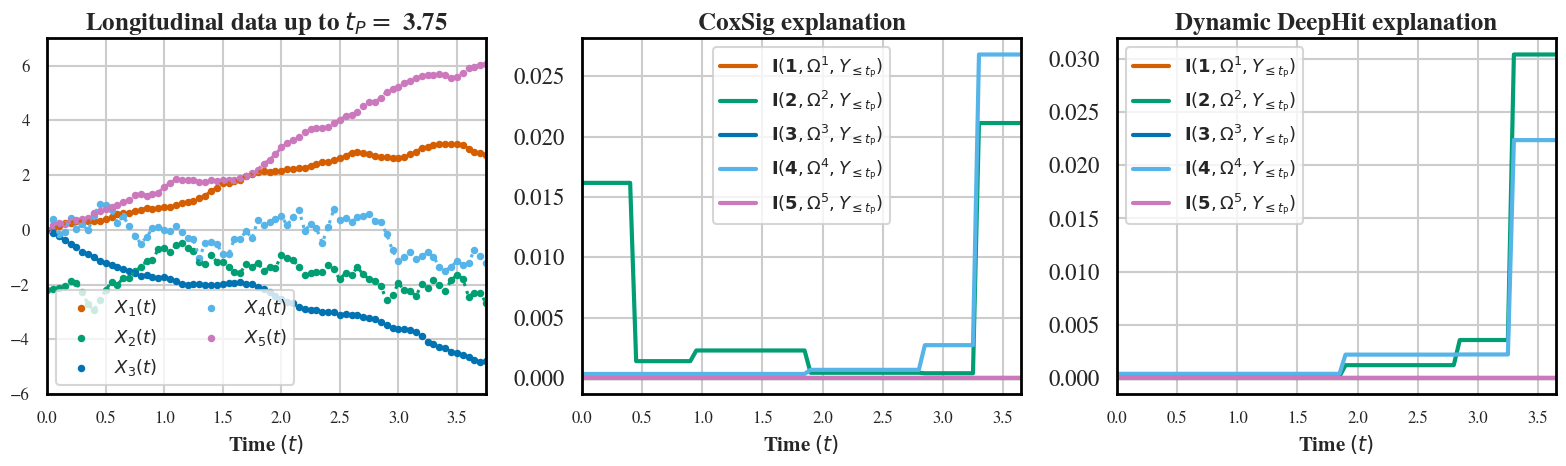

In [12]:
colors = ['r', 'g', 'b', 'c', 'm']

time_step = sampling_times[1] - sampling_times[0]
sel_pred_time_id = 1
pred_time = pred_times[sel_pred_time_id]

j = 0
for i in range(n_samples):
    if (surv_labels[i, 0] > pred_time + .5):
        if i == 270:
            fig, axs = plt.subplots(1, 3, figsize=(16,5))

            for ax in fig.axes:
                [x.set_linewidth(2) for x in ax.spines.values()]
                [x.set_edgecolor('black') for x in ax.spines.values()]
            all_shap = np.array(all_shap_CoxSig)
            a, b = np.asarray(all_shap[sel_pred_time_id][j][0], dtype=float), np.asarray(all_shap[sel_pred_time_id][j][1], dtype=float)
            shap_value = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)

            for l in range(n_longi_feats):
                label = f"${{\mathbf{{I}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
                axs[1].plot(sampling_times, shap_value[l], label=label, linewidth=3, color=colors[l])
            axs[1].set_title("CoxSig explanation", fontsize=18, fontweight="semibold")
            axs[1].set_xlabel("Time $(t)$", fontsize=15, fontweight="bold")
            axs[1].tick_params(axis='x', labelsize=12)
            axs[1].set_xlim(0, pred_time - 2 * time_step)
            axs[1].legend(loc='upper center', ncols=1, fontsize=13)


            all_shap = np.array(all_shap_DDH)
            a, b = np.asarray(all_shap[sel_pred_time_id][j][0], dtype=float), np.asarray(all_shap[sel_pred_time_id][j][1], dtype=float)
            shap_value = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)

            for l in range(n_longi_feats):
                label = f"${{\mathbf{{I}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
                axs[2].plot(sampling_times, shap_value[l], label=label, linewidth=3, color=colors[l])
            axs[2].set_title("Dynamic DeepHit explanation", fontsize=18, fontweight="semibold")
            axs[2].set_xlabel("Time $(t)$", fontsize=15, fontweight="bold")
            axs[2].tick_params(axis='x', labelsize=12)
            axs[2].set_xlim(0, pred_time - 2 * time_step)
            axs[2].legend(loc='upper left', ncols=1, fontsize=13)

            sampling_times = paths[i, :, 0]
            for l, ts in enumerate(paths[i, :, 1:].T):
                axs[0].plot(sampling_times, ts, color=colors[l], linestyle='dotted')
                axs[0].scatter(sampling_times, ts, color=colors[l], s=15, label=f"$X_{{{l+1}}}(t)$")
            time_step = sampling_times[1] - sampling_times[0]
            axs[0].set_title("Longitudinal data up to $t_P = $ {:.2f}".format(pred_time), fontweight="semibold", fontsize=18)
            axs[0].legend(ncols=2, fontsize=13, loc="lower left")
            axs[0].set_xlabel("Time $(t)$", fontsize=15, fontweight="bold")
            axs[0].set_xlim(0, pred_time)
            axs[0].tick_params(axis='x', labelsize=12) 
            axs[0].tick_params(axis='y', labelsize=12) 
            axs[0].set_ylabel("")
            axs[0].set_ylim(-6, 7)
            plt.tight_layout()
            plt.savefig('figures/shap_simu_expl_local.pdf')
            plt.show()
        j +=1


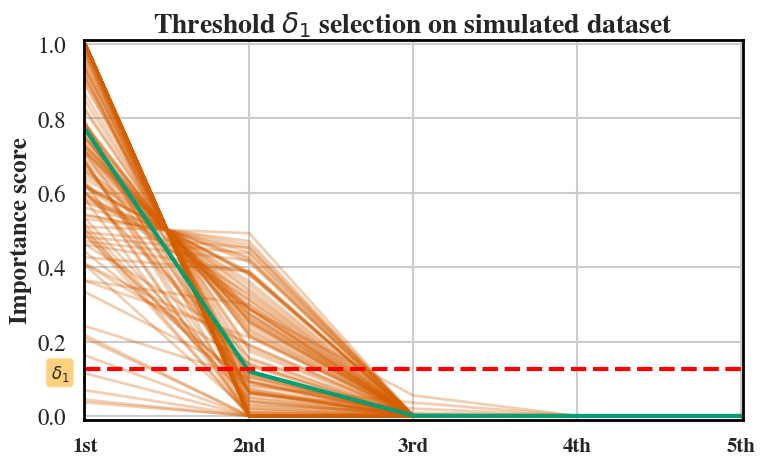

In [13]:
idx_pred_t = 1
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)


fig, axs = plt.subplots(1, 1, figsize=(8,5))
props1 = dict(boxstyle='round', facecolor='orange', alpha=0.5)

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

res = np.nansum(np.array(shap_at_pt)[:, :n_longi_feats], axis=-1)

ax = fig.axes[0]
new_res = []
for tmp in res:
    if not np.all(tmp == 0):
        ax.plot(np.sort(tmp)[::-1], color='r', linewidth=2, zorder=1, alpha=.3)
        new_res.append(np.sort(tmp)[::-1])

mean = np.mean(np.array(new_res), axis=0)
ax.plot(np.arange(n_longi_feats), mean, color='g', linewidth=3, zorder=2)
ax.hlines(xmin=0, xmax=4, y=1./8, linewidth=3, color='red',linestyle='--')
ax.set_xlim(-0.01, 4.01)
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel("Importance score", fontsize=18, fontweight="semibold")
ax.set_xticks(np.arange(0, n_longi_feats))
ax.set_xticklabels(["1st", "2nd", "3rd", "4th", "5th"], fontsize=15, fontweight="semibold")
ax.text(-0.05, .15, '$\delta_1$', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props1)
ax.set_title("Threshold $\delta_1$ selection on simulated dataset", fontsize=20, fontweight="semibold")
plt.tight_layout()


### Median survival time as prediction function

In [14]:
all_shap_CoxSig= np.load('results/shap_simu_med_CoxSig.npy', allow_pickle=True)
all_shap_DDH= np.load('results/shap_simu_med_DDH.npy', allow_pickle=True)
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.5, .75])
pred_times = np.quantile(np.array(tte), quantile_pred_times)

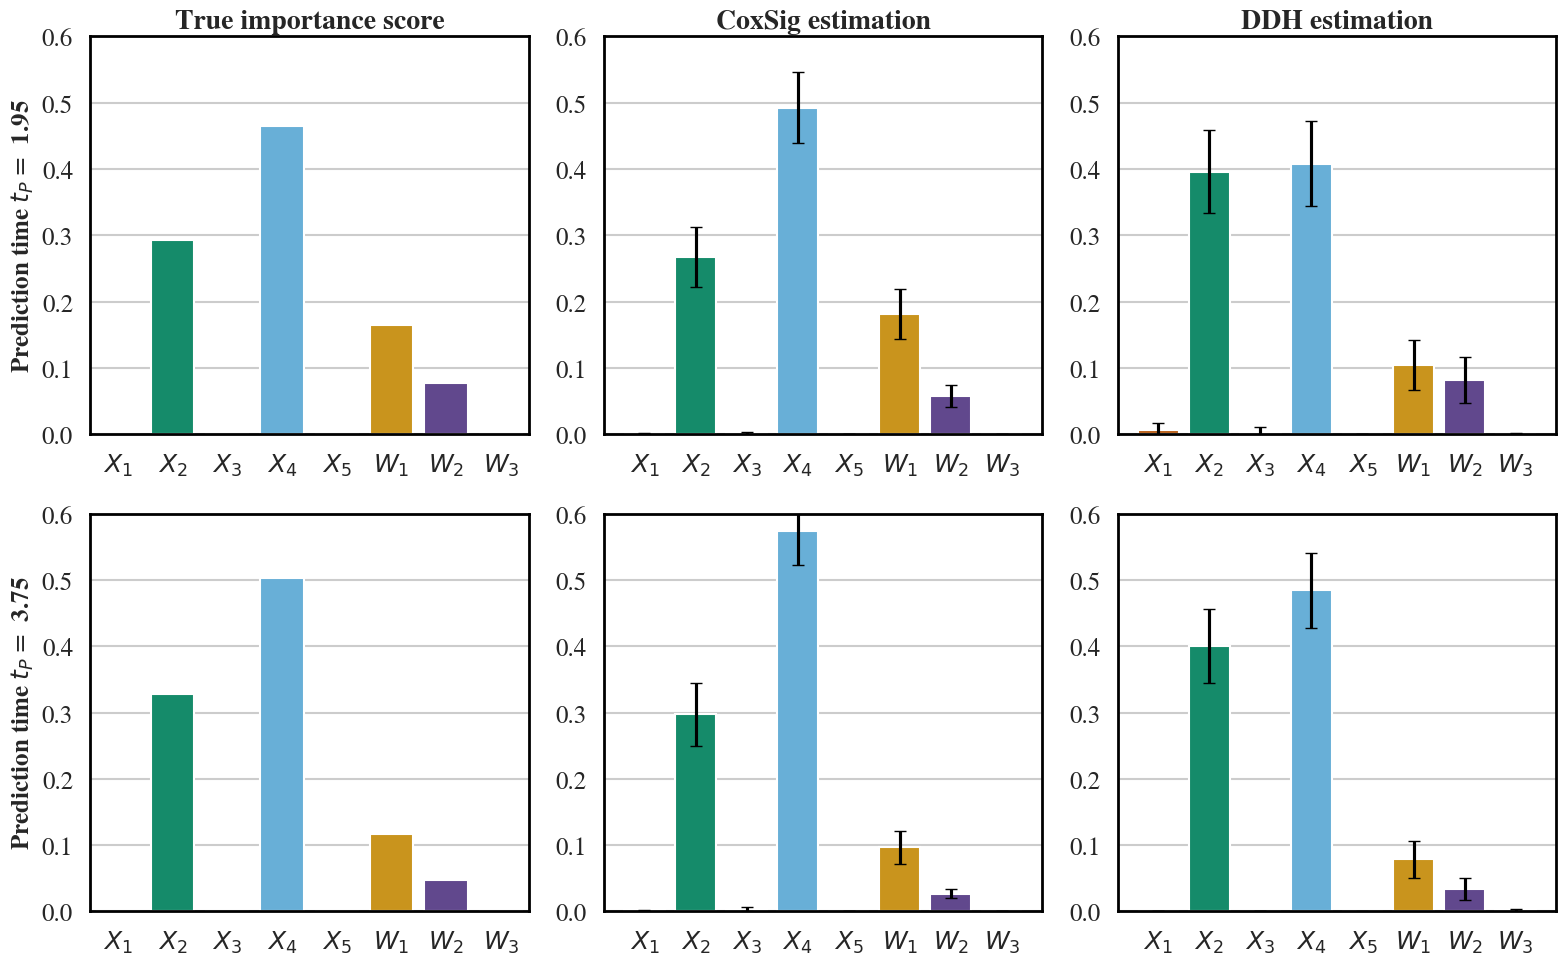

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
n_static_feat = static_feature.shape[1]
x_labels = ["$X_" + str(i + 1) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i + 1) + "$" for i in range(n_static_feat)]
dt = sampling_times[1] - sampling_times[0]

idx_pred_t = 0
pred_time = pred_times[idx_pred_t]
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)

n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
n_merged_time = 5
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx-1:pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
factor_avg = (
    factor_ext
    .reshape(factor_ext.shape[0], -1, n_merged_time)
    .mean(axis=2, keepdims=True)
    .repeat(n_merged_time, axis=2)
    .reshape(factor_ext.shape[0], n_sampling_times)
)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)
sns.barplot(data=score_df, x="feat", y="value", ax=axs[0, 0], palette=colors)
axs[0, 0].tick_params(axis='x', labelsize=18) 
axs[0, 0].tick_params(axis='y', labelsize=18)
axs[0, 0].set_xlabel("")
axs[0, 0].set_ylabel("")
axs[0, 0].set_ylim(0, .6)
axs[0, 0].set_title("True importance score", fontweight="semibold", fontsize=20) 
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")


##################  ESTIMATION   ########################
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[0, 1], palette=colors)
axs[0, 1].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[0, 1].tick_params(axis='x', labelsize=18) 
axs[0, 1].tick_params(axis='y', labelsize=18)
axs[0, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[0, 1].set_ylim(0, .6)
axs[0, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)




shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[0, 2], palette=colors)
axs[0, 2].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[0, 2].tick_params(axis='x', labelsize=18) 
axs[0, 2].tick_params(axis='y', labelsize=18)
axs[0, 2].set_xlabel("")
axs[0, 2].set_ylabel("")
axs[0, 2].set_ylim(0, .6)
axs[0, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)



idx_pred_t = 1
pred_time = pred_times[idx_pred_t]
n_merged_time = 5
pred_time_idx = (int((pred_time  / (sampling_times[1] - sampling_times[0]))) // n_merged_time) * n_merged_time
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx-1:pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
factor_avg = (
    factor_ext
    .reshape(factor_ext.shape[0], -1, n_merged_time)
    .mean(axis=2, keepdims=True)
    .repeat(n_merged_time, axis=2)
    .reshape(factor_ext.shape[0], n_sampling_times)
)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)
sns.barplot(data=score_df, x="feat", y="value", ax=axs[1, 0], palette=colors)
axs[1, 0].tick_params(axis='x', labelsize=18) 
axs[1, 0].tick_params(axis='y', labelsize=18)
axs[1, 0].set_xlabel("")
axs[1, 0].set_ylabel("")
axs[1, 0].set_ylim(0, .6)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx) * dt), fontsize=18, fontweight="semibold")


##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[1, 1], palette=colors)
axs[1, 1].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[1, 1].tick_params(axis='x', labelsize=18) 
axs[1, 1].tick_params(axis='y', labelsize=18)
axs[1, 1].set_xlabel("")
axs[1, 1].set_ylabel("")
axs[1, 1].set_ylim(0, .6)




shap_at_pt = []
all_shap = np.array(all_shap_DDH)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[1, 2], palette=colors)
axs[1, 2].errorbar(
    x=np.arange(std_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=std_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[1, 2].tick_params(axis='x', labelsize=18) 
axs[1, 2].tick_params(axis='y', labelsize=18)
axs[1, 2].set_xlabel("")
axs[1, 2].set_ylabel("")
axs[1, 2].set_ylim(0, .6)


plt.tight_layout()
plt.savefig('figures/shap_simu_med_score_per_feat.pdf')
plt.show()

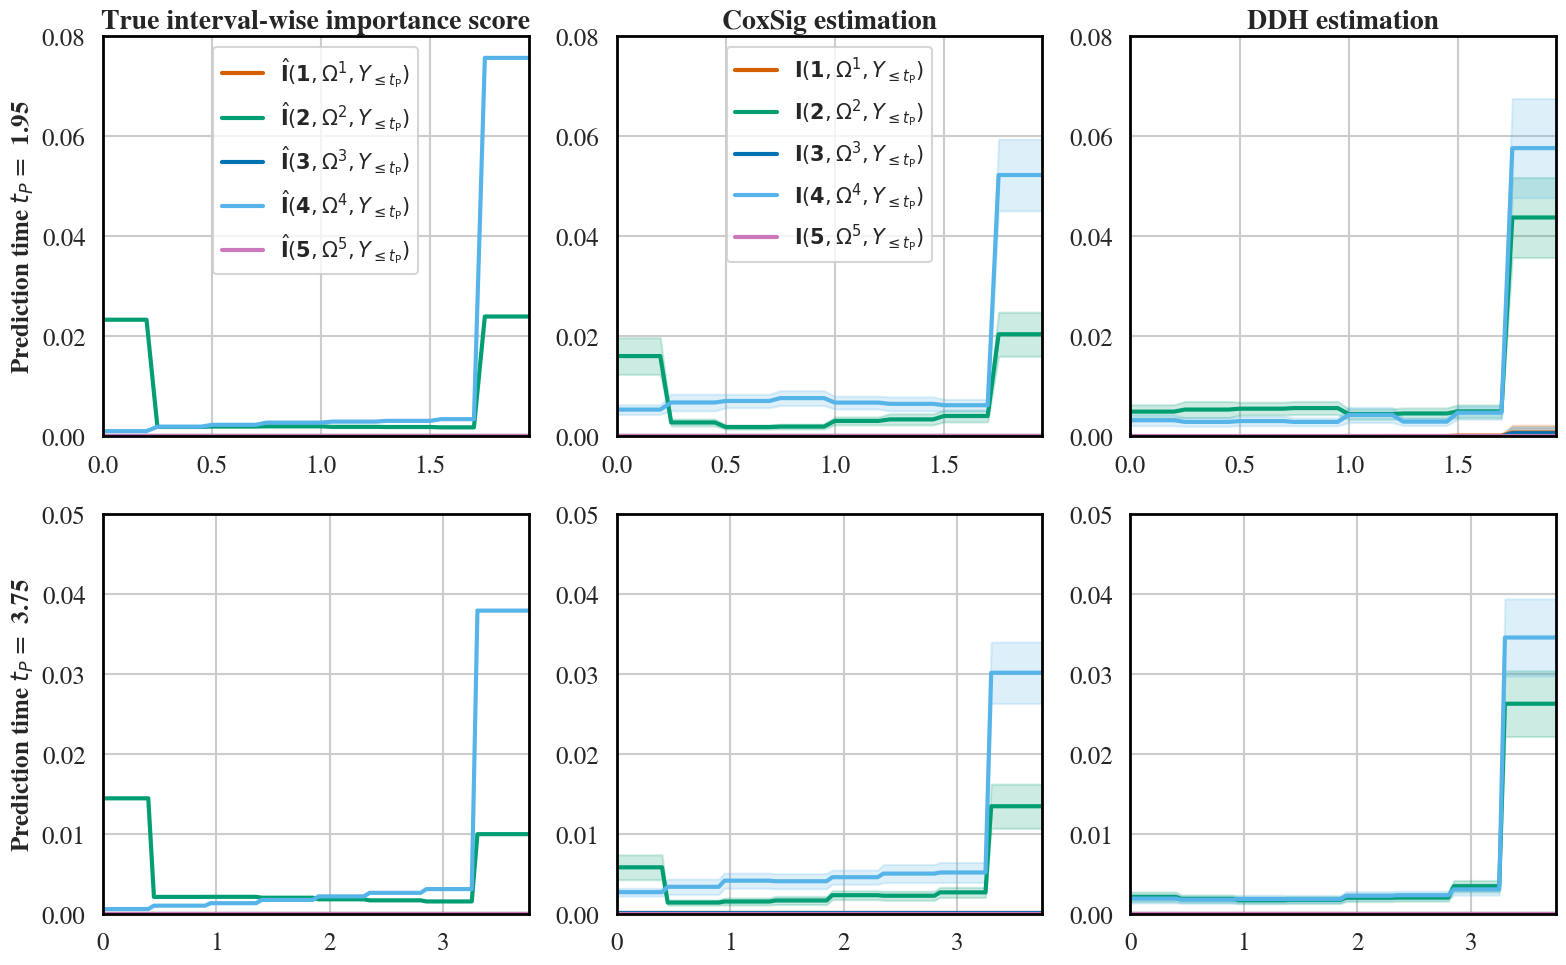

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16,10))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
x_labels = ["$X_" + str(i) + "$" for i in range(n_longi_feats)] + ["$W_" + str(i) + "$" for i in range(n_static_feat)]

idx_pred_t = 0
dt = sampling_times[1] - sampling_times[0]
##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))

pred_time = pred_times[idx_pred_t]
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx -1 :pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
interval = [0 , 5, 10, 15, 21, 26, 31, 35, 40]
factor_avg = factor_ext.copy()
for l in range(len(interval) - 1):
    factor_avg[:, interval[l] : interval[l+1]] = factor_avg[:, interval[l] : interval[l+1]].mean(axis=1).reshape(-1, 1)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)

# ---- LONGITUDINAL feature importance
for l, f in enumerate(factor_avg[:n_longi_feats]):
    label = f"${{\\hat{{\mathbf{{I}}}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[0, 0].plot(sampling_times[: len(f)][:pred_time_idx], f[:pred_time_idx], label=label, linewidth=3, color=colors[l % len(colors)], linestyle="-")
axs[0, 0].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 0].tick_params(axis='x', labelsize=18)
axs[0, 0].tick_params(axis='y', labelsize=18)
axs[0, 0].set_ylim(0, .08)
axs[0, 0].set_xlim(0, (pred_time_idx - 1) * dt)
axs[0, 0].set_title("True interval-wise importance score", fontweight="semibold", fontsize=20)
axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
# axs[0, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx + 1) * dt), fontsize=18, fontweight="semibold")

for l in range(n_longi_feats):
    label = f"${{\mathbf{{I}}}}(\mathbf" + "{" + str(l+1) + "}" + ",\Omega^" + "{" + str(l+1) + "}" + ",Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[0, 1].plot(sampling_times, mean_shap_at_pt[l], linewidth=3, color=colors[l], label=label)
    axs[0, 1].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[0, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
axs[0, 1].legend(ncols=1, fontsize=15, loc="upper center")
axs[0, 1].tick_params(axis='x', labelsize=18) 
axs[0, 1].tick_params(axis='y', labelsize=18)
axs[0, 1].set_ylim(0, .08)
axs[0, 1].set_xlim(0, (pred_time_idx - 1) * dt)

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
# n_expl_samples = all_shap.shape[1]
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
for l in range(n_longi_feats):
    axs[0, 2].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[0, 2].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[0, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[0, 2].tick_params(axis='x', labelsize=18) 
axs[0, 2].tick_params(axis='y', labelsize=18)
axs[0, 2].set_ylim(0, .08)
axs[0, 2].set_xlim(0, (pred_time_idx - 1) * dt)


idx_pred_t = 1
dt = sampling_times[1] - sampling_times[0]
##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_CoxSig)
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))


pred_time = pred_times[idx_pred_t]
pred_time_idx = np.sum(~np.isnan(mean_shap_at_pt[0]))
factor_sel = []
for i in range(n_samples):
    if surv_times[i] > pred_time:
        factor_sel.append(factor.T[i][:, pred_time_idx -1 :pred_time_idx])
factor_ext = np.nanmean(np.array(factor_sel).T, axis=1).mean(axis=-1)
interval = [0 , 9, 19, 28, 38, 47, 57, 66, 76]
factor_avg = factor_ext.copy()
for l in range(len(interval) - 1):
    factor_avg[:, interval[l] : interval[l+1]] = factor_avg[:, interval[l] : interval[l+1]].mean(axis=1).reshape(-1, 1)
factor_avg[factor_avg == 0] = 1e-6

# ---- feature importance
factor_per_feat = factor_avg[:, :pred_time_idx].sum(axis=1)
score_df = pd.DataFrame(np.array([x_labels, factor_per_feat.tolist()]).T, columns = ["feat", "value"])
score_df["value"] = score_df["value"].astype(float)

# ---- LONGITUDINAL feature importance
for l, f in enumerate(factor_avg[:n_longi_feats]):
    label = f"${{\\hat{{\mathbf{{I}}}}}}(\mathbf{{l+1}},\Omega^{l+1},Y_{{\leq t_{{\mathrm{{P}}}}}})$"
    axs[1, 0].plot(sampling_times[: len(f)][:pred_time_idx], f[:pred_time_idx], label=label, linewidth=3, color=colors[l % len(colors)], linestyle="-")
# axs[1, 0].legend(ncols=2, fontsize=12, loc="upper left")
axs[1, 0].legend().remove()
axs[1, 0].tick_params(axis='x', labelsize=18)
axs[1, 0].tick_params(axis='y', labelsize=18)
axs[1, 0].set_ylim(0, .05)
axs[1, 0].set_xlim(0, (pred_time_idx - 1) * dt)
# axs[1, 0].set_title("True interval-wise importance score", fontweight="semibold", fontsize=20)
axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx - 1) * dt), fontsize=18, fontweight="semibold")
# axs[1, 0].set_ylabel("Prediction time $t_P = $ {:.2f}".format((pred_time_idx) * dt), fontsize=18, fontweight="semibold")

for l in range(n_longi_feats):
    axs[1, 1].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1, 1].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
# axs[1, 1].set_title("CoxSig estimation", fontweight="semibold", fontsize=20)
axs[1, 1].tick_params(axis='x', labelsize=18) 
axs[1, 1].tick_params(axis='y', labelsize=18)
axs[1, 1].set_ylim(0, .05)
axs[1, 1].set_xlim(0, (pred_time_idx - 1) * dt)

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap_DDH)
# n_expl_samples = all_shap.shape[1]
n_expl_samples = len(all_shap[idx_pred_t])
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0) / np.sqrt(len(shap_at_pt))
# std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0)
for l in range(n_longi_feats):
    axs[1, 2].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1, 2].fill_between(sampling_times, mean_shap_at_pt[l] - 1.96 * std_shap_at_pt[l], mean_shap_at_pt[l] + 1.96 * std_shap_at_pt[l], color=colors[l], alpha=0.2)
    # axs[1, 2].fill_between(sampling_times, mean_shap_at_pt[l] - std_shap_at_pt[l], mean_shap_at_pt[l] + std_shap_at_pt[l], color=colors[l], alpha=0.2)
# axs[1, 2].set_title("DDH estimation", fontweight="semibold", fontsize=20)
axs[1, 2].tick_params(axis='x', labelsize=18) 
axs[1, 2].tick_params(axis='y', labelsize=18)
axs[1, 2].set_ylim(0, .05)
axs[1, 2].set_xlim(0, (pred_time_idx - 1) * dt)

plt.tight_layout()
plt.savefig('figures/shap_simu_med_score_per_longi.pdf')
plt.show()

### Other figures

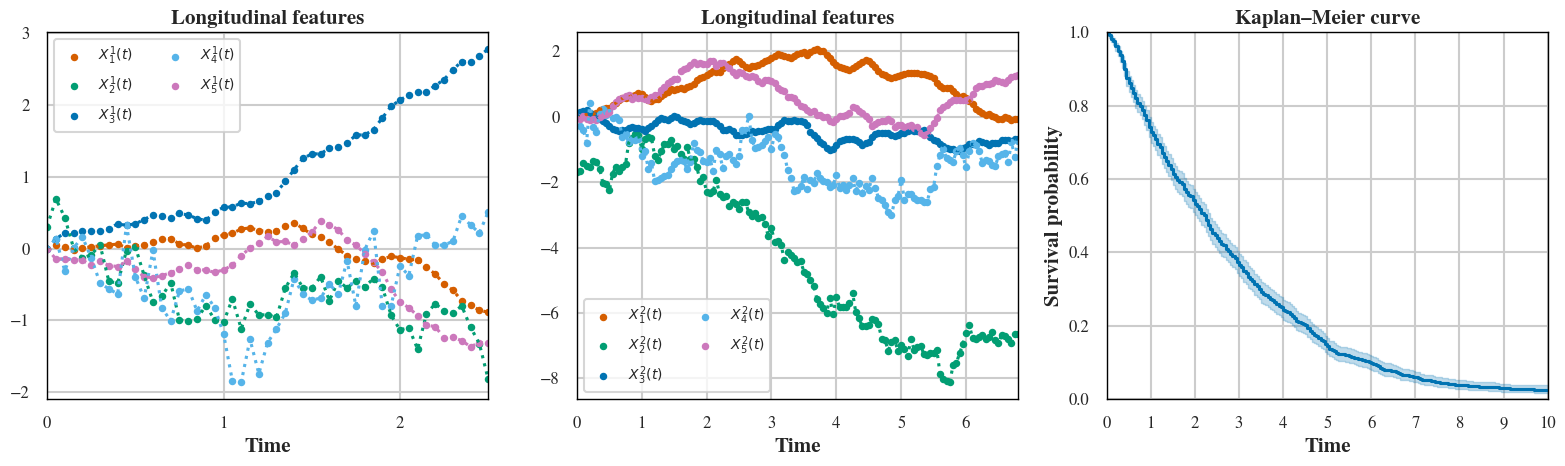

In [17]:
from lifelines import KaplanMeierFitter

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

plt.subplots_adjust(hspace=.35, wspace=0.3)
colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]

sel_idx = 2
sampling_times = paths[sel_idx,:,0]
n_samples = paths.shape[0]
n_longi = paths.shape[-1] - 1
n_sampling_times = paths.shape[1]
n_static_feats = static_feature.shape[1]
dt = sampling_times[1] - sampling_times[0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]

# ---- longitudinal paths
for l, ts in enumerate(paths[sel_idx, :, 1:].T):
    axs[0].plot(sampling_times[:int(surv_times[sel_idx] / dt)], ts[:int(surv_times[sel_idx] / dt)], color=colors[l], linestyle='dotted')
    axs[0].scatter(sampling_times[:int(surv_times[sel_idx] / dt)], ts[:int(surv_times[sel_idx] / dt)], color=colors[l], s=15, label=f"$X^1_{{{l+1}}}(t)$")
axs[0].set_title("Longitudinal features", fontweight="semibold", fontsize=15)
axs[0].legend(ncols=2, fontsize=10, loc="upper left")
axs[0].set_xlabel("Time", fontweight="semibold", fontsize=15) 
axs[0].tick_params(axis='x', labelsize=12) 
axs[0].tick_params(axis='y', labelsize=12) 
axs[0].set_xticks(np.arange(0, surv_times[sel_idx], 1))
axs[0].set_xticklabels(np.arange(0, surv_times[sel_idx], 1).astype(int))
axs[0].set_ylabel("") 
axs[0].set_xlim(min(sampling_times), max(sampling_times[:int(surv_times[sel_idx] / dt)]))


sel_idx = 20

# ---- longitudinal paths
for l, ts in enumerate(paths[sel_idx, :, 1:].T):
    axs[1].plot(sampling_times[:int(surv_times[sel_idx] / dt)], ts[:int(surv_times[sel_idx] / dt)], color=colors[l], linestyle='dotted')
    axs[1].scatter(sampling_times[:int(surv_times[sel_idx] / dt)], ts[:int(surv_times[sel_idx] / dt)], color=colors[l], s=15, label=f"$X^2_{{{l+1}}}(t)$")
axs[1].set_title("Longitudinal features", fontweight="semibold", fontsize=15)
axs[1].legend(ncols=2, fontsize=10, loc="lower left")
axs[1].set_xlabel("Time", fontweight="semibold", fontsize=15) 
axs[1].tick_params(axis='x', labelsize=12) 
axs[1].tick_params(axis='y', labelsize=12)
axs[1].set_xticks(np.arange(0, surv_times[sel_idx], 1))
axs[1].set_xticklabels(np.arange(0, surv_times[sel_idx], 1).astype(int))
axs[1].set_ylabel("") 
axs[1].set_xlim(min(sampling_times), max(sampling_times[:int(surv_times[sel_idx] / dt)]))

kmf = KaplanMeierFitter()
kmf.fit(durations=surv_times, event_observed=surv_inds, label="KM estimate")

kmf.plot_survival_function(ci_show=True, ax=axs[2])
axs[2].set_xlabel("Time", fontweight="semibold", fontsize=15)
axs[2].set_ylabel("Survival probability", fontweight="semibold", fontsize=15)
axs[2].legend().remove()
axs[2].set_title("Kaplan–Meier curve", fontweight="semibold", fontsize=15)
axs[2].tick_params(axis='x', labelsize=12) 
axs[2].tick_params(axis='y', labelsize=12)
axs[2].set_xticks(np.arange(0, 10.1, 1))
axs[2].set_xticklabels(np.arange(0, 10.1, 1).astype(int))
axs[2].set_xlim(0, 10)
axs[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('results/simu_data.pdf')
plt.show()

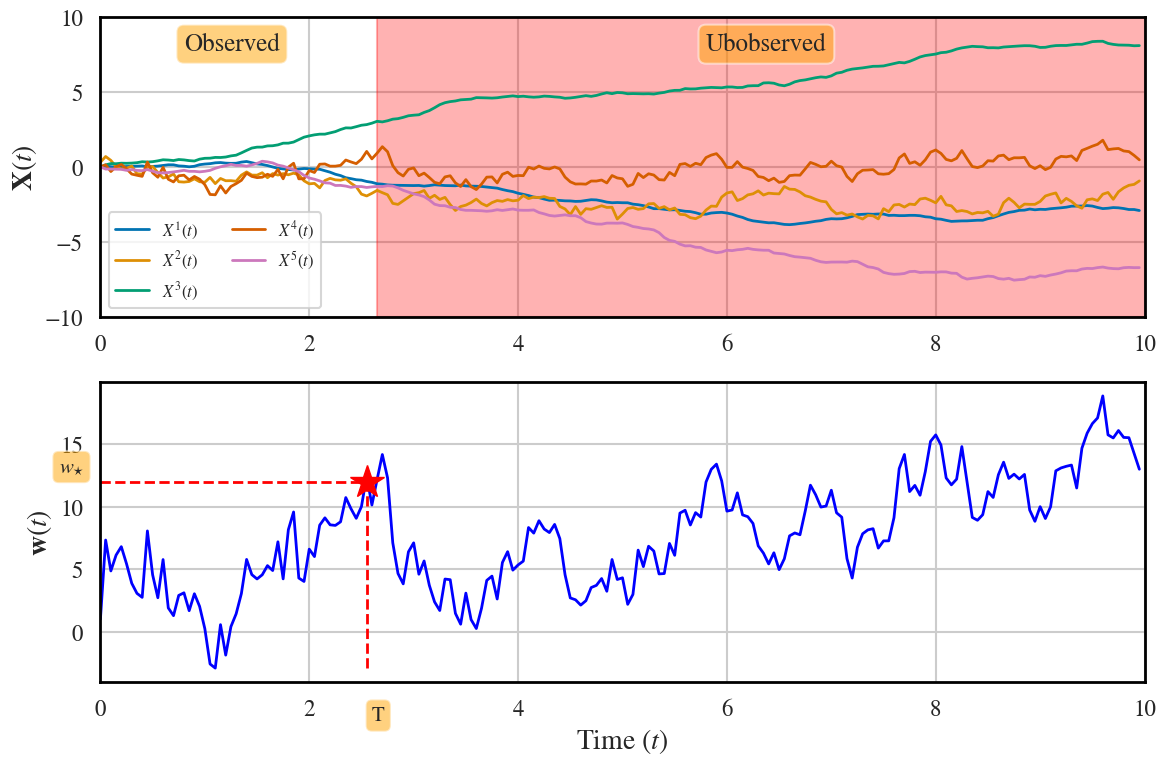

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")
props1 = dict(boxstyle='round', facecolor='orange', alpha=0.5)

sns.set_style('whitegrid')
sns.set_palette('colorblind')

rand_int=2
surv_time_idx  = int(surv_times[rand_int] / (org_paths[0,1,0] - org_paths[0,0,0]))
#np.random.choice(20)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
f,ax=plt.subplots(2,1,figsize=(12,8))
for k in range(5):
    ax[0].plot(org_paths[0,:,0], org_paths[rand_int,:,k+1],linewidth=2, label="$X^{}(t)$".format(k+1))
ax[0].fill_between(x=org_paths[0,:,0][surv_time_idx:] + 0.1, y1=-10, y2=10, alpha=0.3, color='red')
ax[1].plot(org_paths[0,:,0], traj[rand_int,:],linewidth=2,c='blue')
ax[1].hlines(12,xmin=0,xmax=surv_times[rand_int],color='red',linestyle='--',linewidth=2)
ax[1].vlines(surv_times[rand_int],ymin=traj[rand_int,:].min(), ymax=12,color='red',linestyle='--',linewidth=2)
ax[1].plot(surv_times[rand_int],12,marker='*',markersize=25,c='red')
ax[0].text(0.58, 0.95, 'Ubobserved', transform=ax[0].transAxes, fontsize=18,
        verticalalignment='top', bbox=props1)
ax[0].text(0.08, 0.95, 'Observed', transform=ax[0].transAxes, fontsize=18,
        verticalalignment='top', bbox=props1)
ax[0].legend(ncols=2, fontsize=12)
for axis in ['top','bottom','left','right']:
    for i in [0,1]:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].spines[axis].set_color('black')
ax[1].set_xlabel('Time $(t)$',fontsize=20)
ax[0].set_ylabel('$\mathbf{X}(t)$',fontsize=20)
ax[1].set_ylabel('$\mathbf{w}(t)$',fontsize=20)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(-10, 10)
ax[1].set_xlim(0, 10)
ax[1].text(-0.04, .75, '$w_{\star}$', transform=ax[1].transAxes, fontsize=15,
        verticalalignment='top', bbox=props1)
ax[1].text(0.26, -.08, 'T', transform=ax[1].transAxes, fontsize=15,
        verticalalignment='top', bbox=props1)

plt.tight_layout()
plt.savefig('figures/OU_path_rnd_individual.pdf')

In [19]:
from stochastic.processes.continuous import FractionalBrownianMotion
fbm = FractionalBrownianMotion(hurst=.5, rng=np.random.default_rng(3))
n_samples = 7
n_time = 100
random_path = np.zeros((1, n_time, n_samples))
for dim in np.arange(n_samples):
    random_path[:,:,dim] = fbm.sample(n=n_time-1, )
tmp = np.arange(-0.1,.9,0.01).reshape(-1, 1)
random_path[0,:,:1] = random_path[0,:,:1] + tmp * 1
random_path[0,:,1:2] = random_path[0,:,1:2] + tmp * 2
random_path[0,:,2:3] = random_path[0,:,2:3] + tmp * 0
random_path[0,:,3:4] = random_path[0,:,3:4] + tmp * -1
random_path[0,:,4:5] = random_path[0,:,4:5] + tmp * 0
random_path[0,:,5:6] = random_path[0,:,5:6] + tmp * -1
random_path[0,:,6:7] = random_path[0,:,6:7] + tmp * -2
time = np.arange(0, 1, step = 1/n_time)

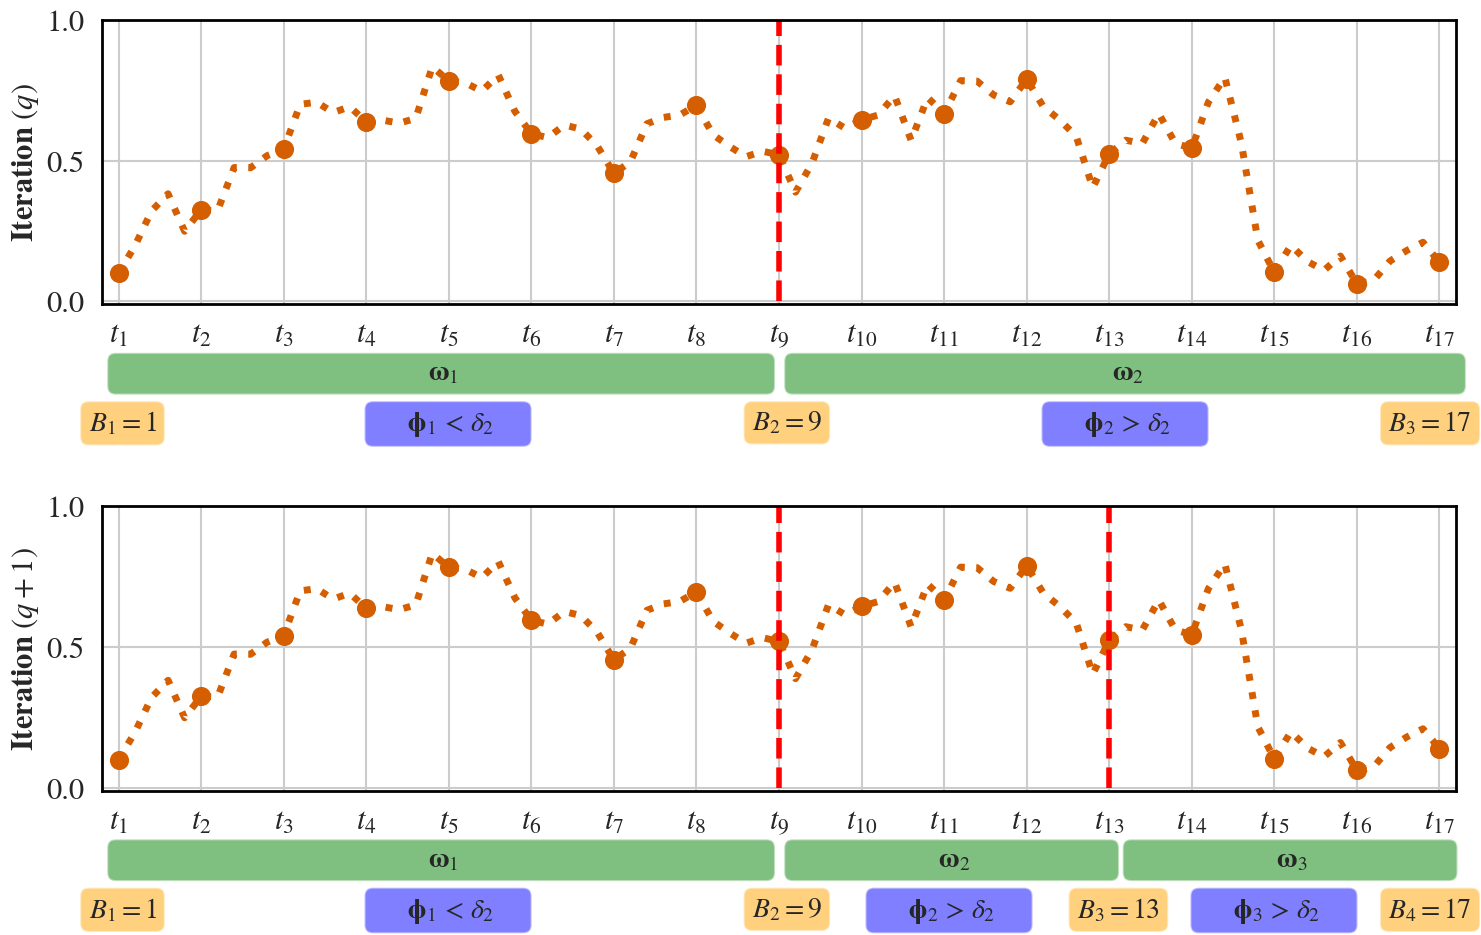

In [20]:
sns.set(style='whitegrid',font="STIXGeneral",context='talk',palette='colorblind')

fig, axs = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(
    wspace=0.5,  # width space between columns
    hspace=.1,   # height space between rows
    right=1.5  # space from right edge
)

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)

props1 = dict(boxstyle='round', facecolor='orange', alpha=0.5)
props = dict(boxstyle='round', facecolor='green', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='blue', alpha=0.5)

axs[0].plot(time[:81],random_path[0,:81,5:6],linewidth=5,
         color='r', linestyle='dotted')
axs[0].scatter(time[:81:5],random_path[0,:81:5,5:6], 
            label='$X_1(t)$', color='r', s=150, marker="o")
axs[0].set_xlim(-0.01, .81)
axs[0].set_ylim(-0.01, 1.)
axs[0].vlines(x=time[40],ymin=0,ymax=1,linewidth=4,color='red',linestyle='--')
# axs[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8])
list_label = np.arange(0, 0.81, 0.05).tolist()
axs[0].set_xticks(list_label)
axs[0].set_xticklabels(["$t_{{{}}}$".format(i+1) for i in range(len(list_label))], fontsize=22)
axs[0].tick_params(axis="y", labelsize=22)
# axs[0].fill_between(x=time[:41:5] - 0.005, y1=0.85, y2=0.99, alpha=0.3, color='red', label="X")

axs[0].text(0.01, -.2, ' '*45 + '$\mathbf{\omega}_1$' + ' '*45 , transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
axs[0].text(0.51, -.2, ' '*46 + '$\mathbf{\omega}_2$' + ' '*46 , transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

axs[0].text(0.2, -.37, ' '*5 + '$\mathbf{\phi}_1$ < $\delta_2$' + ' '*5 , transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props2)
axs[0].text(0.7, -.37, ' '*5 + '$\mathbf{\phi}_2$ > $\delta_2$' + ' '*5 , transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props2)

axs[0].text(-0.01, -.37, '$B_1 = 1$', transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[0].text(0.48, -.37, '$B_2 = 9$', transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[0].text(0.95, -.37, '$B_3 = 17$', transform=axs[0].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[0].set_ylabel('Iteration $(q)$',fontsize=22, fontweight="bold")



axs[1].plot(time[:81],random_path[0,:81,5:6],linewidth=5,
         color='r', linestyle='dotted')
axs[1].scatter(time[:81:5],random_path[0,:81:5,5:6], 
            label='$X_1(t)$', color='r', s=150, marker="o")
axs[1].set_xlim(-0.01, .81)
axs[1].vlines(x=time[40],ymin=0,ymax=1,linewidth=4,color='red',linestyle='--')
axs[1].vlines(x=time[60],ymin=0,ymax=1,linewidth=4,color='red',linestyle='--')
axs[1].set_xlim(-0.01, .81)
axs[1].set_ylim(-0.01, 1.)
list_label = np.arange(0, 0.81, 0.05).tolist()
axs[1].set_xticks(list_label)
axs[1].set_xticklabels(["$t_{{{}}}$".format(i+1) for i in range(len(list_label))], fontsize=22)
axs[1].tick_params(axis="y", labelsize=22)
axs[1].text(-0.01, -.37, '$B_1 = 1$', transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[1].text(0.48, -.37, '$B_2 = 9$', transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[1].text(0.72, -.37, '$B_3 = 13$', transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)
axs[1].text(0.95, -.37, '$B_4 = 17$', transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props1)

axs[1].text(0.01, -.2, ' '*45 + '$\mathbf{\omega}_1$' + ' '*45 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
axs[1].text(0.51, -.2, ' '*21 + '$\mathbf{\omega}_2$' + ' '*21 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
axs[1].text(0.76, -.2, ' '*21 + '$\mathbf{\omega}_3$' + ' '*21 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
axs[1].text(0.2, -.37, ' '*5 + '$\mathbf{\phi}_1$ < $\delta_2$' + ' '*5 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props2)
axs[1].text(0.57, -.37, ' '*5 + '$\mathbf{\phi}_2$ > $\delta_2$' + ' '*5 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props2)
axs[1].text(0.81, -.37, ' '*5 + '$\mathbf{\phi}_3$ > $\delta_2$' + ' '*5 , transform=axs[1].transAxes, fontsize=20,
        verticalalignment='top', bbox=props2)
axs[1].set_ylabel('Iteration $(q + 1)$',fontsize=22, fontweight="bold")
plt.tight_layout()
plt.savefig('figures/LongisurvSHAP.pdf')

In [21]:
def compute_factor(T, delta_t, coef_list, theta_list):
    factor = []
    time_grid = np.arange(0, T, delta_t)
    for l, coef_l in enumerate(coef_list):
        factor_l = []
        for t, time in enumerate(time_grid):
            if t == len(time_grid) - 1:
                factor_l.append(coef_l)
            elif t == 0:
                factor_l.append(coef_l * (1 - theta_list[l] * delta_t)**(len(time_grid) - t))
            else:
                factor_l.append(coef_l * delta_t * theta_list[l] * (1 - theta_list[l] * delta_t)**(len(time_grid) - t))
        factor.append(factor_l)

    return np.array(factor)

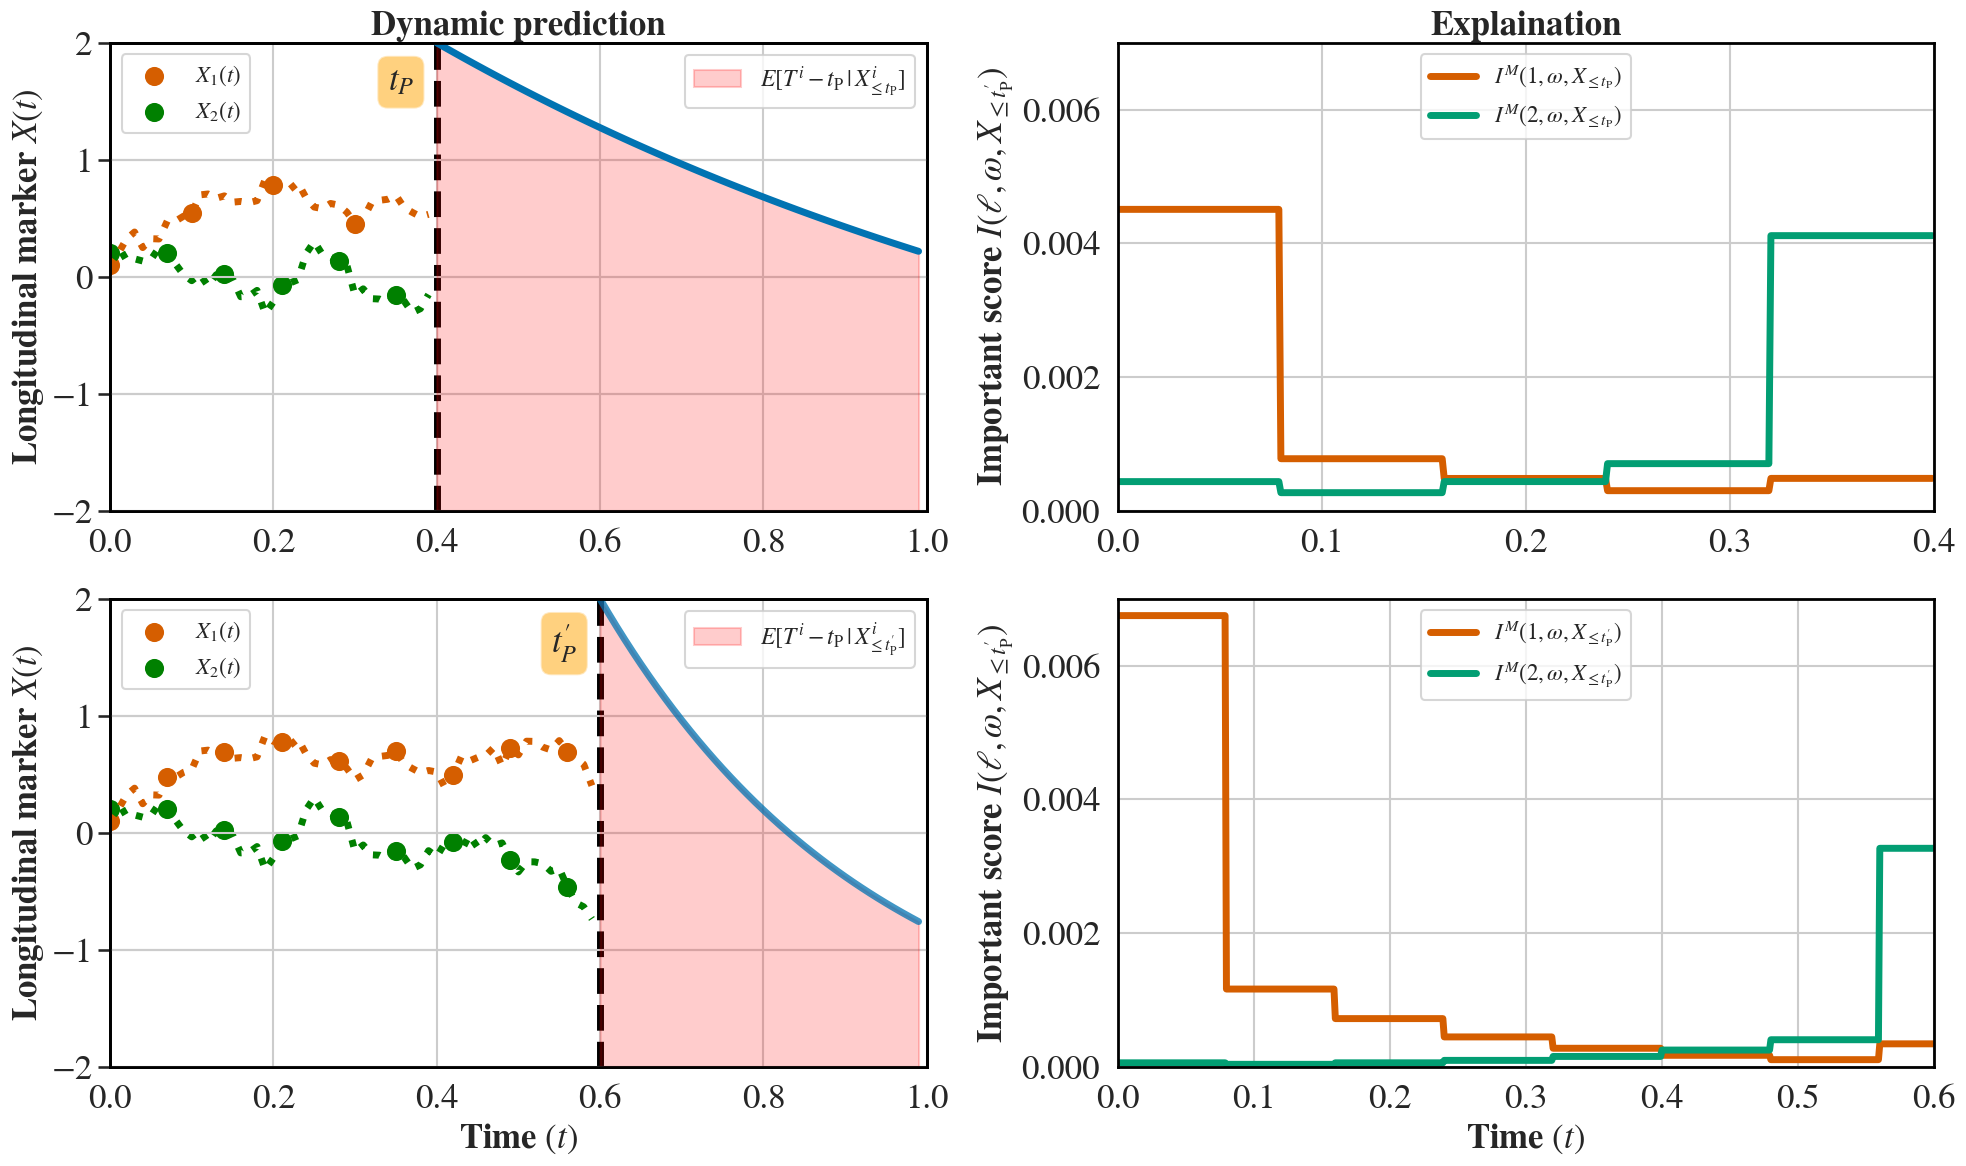

In [22]:
sns.set(style='whitegrid',font="STIXGeneral",context='talk',palette='colorblind')

fig, axs = plt.subplots(2, 2, figsize=(20,12))
fig.subplots_adjust(
    wspace=0.3,  # width space between columns
    hspace=0.2   # height space between rows
)

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)

props1 = dict(boxstyle='round', facecolor='orange', alpha=0.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

axs[0, 0].plot(time[:40],random_path[0,:40,5:6],linewidth=5,
         color='r', linestyle='dotted')
axs[0, 0].scatter(time[:40:10],random_path[0,:40:10,5:6], 
            label='$X_1(t)$', color='r', s=150, marker="o")
axs[0, 0].plot(time[:40],random_path[0,:40,6:7],linewidth=5,
         color='#008000', linestyle='dotted')
axs[0, 0].scatter(time[:40:7],random_path[0,:40:7,6:7], 
            label='$X_2(t)$', color='#008000', s=150, marker="o")
axs[0, 0].vlines(x=time[40],ymin=-2,ymax=2,linewidth=5,color='black',linestyle='--')

ax1_ = axs[0, 0].twinx()  # instantiate a second axes that shares the same x-axis
ax1_.plot(time[40:],np.exp(- 1 * (time[40:] - time[40])), linewidth=5, color='b')
area = ax1_.fill_between(time[40:], np.exp(- 1 * (time[40:] - time[40])), alpha=0.2, color='red')
ax1_.legend([area], ["$E[T^i - t_{\mathrm{P}} \, | \, X^i_{\leq t_{\mathrm{P}}}]$"], loc='upper right',fontsize=17)

axs[0, 0].set_ylim(-2, 2)
axs[0, 0].set_xlim(0, 1)
axs[0, 0].legend(loc='upper left')

ax1_.set_ylim(0, 1)
ax1_.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1_.set_yticklabels([], fontsize=25)
ax1_.tick_params(axis="y", length=0)   # y-axis only
# ax1_.legend(loc='upper right')
[x.set_linewidth(2) for x in ax1_.spines.values()]
[x.set_edgecolor('black') for x in ax1_.spines.values()]
ax1_.tick_params(axis='both', which='major', labelsize=25)
ax1_.tick_params(axis='both', which='minor', labelsize=25)
# ax1.set_title('Dynamic prediction with 1st prediction time', fontsize=25, fontweight="bold")
axs[0, 0].set_title('Dynamic prediction', fontsize=25, fontweight="bold")
axs[0, 0].text(0.34, .95, '$t_P$', transform=axs[0, 0].transAxes, fontsize=25, verticalalignment='top', bbox=props1)
axs[0, 0].set_ylabel('Longitudinal marker $X(t)$',fontsize=25, fontweight="bold")

factor = compute_factor(4., 0.01, [0, 1., 0, 10.01, 0], [0, -.6, 0, .6, 0])
factor_ext = np.abs(factor) / np.abs(factor).sum()
factor_ext_int = []
delta_t = 80
for l, factor_l in enumerate(factor_ext):
    t = 0
    factor_l_ext = []
    while t < len(factor_l):
        factor_l_ext += [np.mean(factor_l[t:t+delta_t])] * len(factor_l[t:t+delta_t])
        t += delta_t
    factor_ext_int.append(factor_l_ext)

axs[0, 1].plot(np.arange(0, 0.4, 0.001), factor_ext_int[1], label='$I^M(1, \omega, X_{\leq t_{\mathrm{P}}})$', linewidth=5, color='r')
axs[0, 1].plot(np.arange(0, 0.4, 0.001), factor_ext_int[3], label='$I^M(2, \omega, X_{\leq t_{\mathrm{P}}})$', linewidth=5, color='g')
axs[0, 1].set_title('Explaination', fontsize=25, fontweight="bold")
# axs[0, 1].set_xlabel("Time $(t)$", fontsize=25, fontweight="bold")
axs[0, 1].set_xlim(0, .4)
axs[0, 1].set_ylim(0, 0.007)
axs[0, 1].set_xticks([0.0, 0.1, 0.2, 0.3, 0.4])
axs[0, 1].set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4], fontsize=25)
# ax1_.set_ylabel("Survival prediction $\pi(t \, | \, t_P^\prime)$", fontsize=25, fontweight="bold")
axs[0, 1].legend(loc='upper center')
axs[0, 1].set_ylabel("Important score $I(\ell, \omega, X_{\leq t_{\mathrm{P}}^\prime})$", fontsize=25, fontweight="bold")

axs[1, 0].plot(time[:60],random_path[0,:60,5:6],linewidth=5,
         color='r', linestyle='dotted')
axs[1, 0].scatter(time[:60:7],random_path[0,:60:7,5:6], 
            label='$X_1(t)$', color='r', s=150, marker="o")
axs[1, 0].plot(time[:60],random_path[0,:60,6:7],linewidth=5,
         color='#008000', linestyle='dotted')
axs[1, 0].scatter(time[:60:7],random_path[0,:60:7,6:7], 
            label='$X_2(t)$', color='#008000', s=150, marker="o")
axs[1, 0].vlines(x=time[60],ymin=-2,ymax=2,linewidth=5,color='black',linestyle='--')
axs[1, 0].set_ylim(-2, 2)
axs[1, 0].set_xlim(0, 1)
axs[1, 0].legend(loc='upper left')
ax1_ = axs[1, 0].twinx()  # instantiate a second axes that shares the same x-axis
ax1_.plot(time[60:],np.exp(- 3 * (time[60:] - time[60])), 
          linewidth=5, color='b', alpha=0.75)
ax1_.set_ylim(0, 1)
ax1_.set_yticks([0.0, 0.25, 0.5, 0.75, 1])
ax1_.set_yticklabels([])
ax1_.tick_params(axis="y", length=0)   # y-axis only
area = ax1_.fill_between(time[60:],np.exp(- 3 * (time[60:] - time[60])), alpha=0.2, color='red')
ax1_.legend([area], ["$E[T^i - t_{\mathrm{P}} \, | \, X^i_{\leq t_{\mathrm{P}}^\prime}]$"], loc='upper right',fontsize=17)
# ax1_.set_ylabel("Survival prediction $\pi(t \, | \, t_P)$", fontsize=25, fontweight="bold")
[x.set_linewidth(2) for x in ax1_.spines.values()]
[x.set_edgecolor('black') for x in ax1_.spines.values()]
ax1_.tick_params(axis='both', which='major', labelsize=25)
ax1_.tick_params(axis='both', which='minor', labelsize=25)
# axs[1, 0].set_title('Dynamic prediction with 2nd prediction time', fontsize=25, fontweight="bold")
axs[1, 0].set_xlabel("Time $(t)$", fontsize=25, fontweight="bold")
axs[1, 0].text(0.54, 0.95, '$t_P^\prime$', transform=axs[1, 0].transAxes, fontsize=25,
        verticalalignment='top', bbox=props1)
axs[1, 0].set_ylabel('Longitudinal marker $X(t)$',fontsize=25, fontweight="bold")

factor = compute_factor(6., 0.01, [0, 1., 0, 10., 0], [0, -.6, 0, .6, 0])
factor_ext = np.abs(factor) / np.abs(factor).sum()
factor_ext_int = []
delta_t = 80
for l, factor_l in enumerate(factor_ext):
    t = 0
    factor_l_ext = []
    while t < len(factor_l):
        factor_l_ext += [np.mean(factor_l[t:t+delta_t])] * len(factor_l[t:t+delta_t])
        t += delta_t
    factor_ext_int.append(factor_l_ext)
axs[1, 1].plot(np.arange(0, 0.6, 0.001), factor_ext_int[1], label='$I^M(1, \omega, X_{\leq t_{\mathrm{P}}^\prime})$', linewidth=5, color='r')
axs[1, 1].plot(np.arange(0, 0.6, 0.001), factor_ext_int[3], label='$I^M(2, \omega, X_{\leq t_{\mathrm{P}}^\prime})$', linewidth=5, color='g')

axs[1, 1].set_ylim(0, 0.007)
axs[1, 1].set_xlim(0, .6)
axs[1, 1].legend(loc='upper center')
# axs[1, 1].set_title('Explaination with 2nd prediction time', fontsize=25, fontweight="bold")
axs[1, 1].set_xlabel("Time $(t)$", fontsize=25, fontweight="bold")
axs[1, 1].set_ylabel("Important score $I(\ell, \omega, X_{\leq t_{\mathrm{P}}^\prime})$", fontsize=25, fontweight="bold")

# plt.show()
plt.tight_layout()
plt.savefig('figures/dynamic_explaination.pdf')
